# IEEE Fraud Detection Kaggle Competition

features from: https://www.kaggle.com/roydatascience/light-gbm-with-complete-eda/notebook#Feature-Engineering

In [277]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [278]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

num_folds = 5
SEED = 5000

In [279]:
import random, os
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything()

In [280]:
sampled_train_original = pd.read_csv('../../output/sampled_train_reduced_mem.csv')
train_original = pd.read_csv('../../output/train_reduced_mem.csv')
test_original = pd.read_csv('../../output/test_reduced_mem.csv')

In [281]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [282]:
# sampled_train_original = reduce_mem_usage(sampled_train_original)
# train_original = reduce_mem_usage(train_original)
# test_original = reduce_mem_usage(test_original)

In [283]:
params = {
                'objective':'binary',
                'boosting_type':'gbdt',
                'metric':'auc',
                'n_jobs':-1,
                'learning_rate':0.064,
                'num_leaves': 2**8,
                'max_depth':-1,
                'tree_learner':'serial',
                'colsample_bytree': 0.85,
                'subsample_freq':1,
                'subsample':0.85,
                'max_bin':255,
                'verbose':-1,
                'seed': SEED,
                'reg_alpha':0.3,
                'reg_lamdba':0.243
            } 
# Uses a lower learning rate - default is 0.1. This is not changed in my notebooks, try again with this change?
# params['learning_rate'] = 0.005
params['learning_rate'] = 0.01
# params['n_estimators'] = 3000
params['n_estimators'] = 550
params['early_stopping_rounds'] = 100    

In [284]:
sampled_train_original.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.98,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,F3213 Build/36.1.

In [285]:
n_days_in_week_21 = 18509

In [286]:
"""
This module provides a class to split time-series data for back-testing and evaluation.
The aim was to extend the current sklearn implementation and extend it's uses.

Might be useful for some ;)
"""

import logging
from typing import Optional

import numpy as np
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples

LOGGER = logging.getLogger(__name__)


class TimeSeriesSplit(_BaseKFold):  # pylint: disable=abstract-method
    """Time Series cross-validator

    Provides train/test indices to split time series data samples that are observed at fixed time intervals,
    in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is
    inappropriate.

    This cross_validation object is a variation of :class:`TimeSeriesSplit` from the popular scikit-learn package.
    It extends its base functionality to allow for expanding windows, and rolling windows with configurable train and
    test sizes and delays between each. i.e. train on weeks 1-8, skip week 9, predict week 10-11.

    In this implementation we specifically force the test size to be equal across all splits.

    Expanding Window:

            Idx / Time  0..............................................n
            1           |  train  | delay |  test  |                   |
            2           |       train     | delay  |  test  |          |
            ...         |                                              |
            last        |            train            | delay |  test  |

    Rolling Windows:
            Idx / Time  0..............................................n
            1           | train   | delay |  test  |                   |
            2           | step |  train  | delay |  test  |            |
            ...         |                                              |
            last        | step | ... | step |  train  | delay |  test  |

    Parameters:
        n_splits : int, default=5
            Number of splits. Must be at least 4.

        train_size : int, optional
            Size for a single training set.

        test_size : int, optional, must be positive
            Size of a single testing set

        delay : int, default=0, must be positive
            Number of index shifts to make between train and test sets
            e.g,
            delay=0
                TRAIN: [0 1 2 3] TEST: [4]
            delay=1
                TRAIN: [0 1 2 3] TEST: [5]
            delay=2
                TRAIN: [0 1 2 3] TEST: [6]

        force_step_size : int, optional
            Ignore split logic and force the training data to shift by the step size forward for n_splits
            e.g
            TRAIN: [ 0  1  2  3] TEST: [4]
            TRAIN: [ 0  1  2  3  4] TEST: [5]
            TRAIN: [ 0  1  2  3  4  5] TEST: [6]
            TRAIN: [ 0  1  2  3  4  5  6] TEST: [7]

    Examples
    --------
    >>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
    >>> y = np.array([1, 2, 3, 4, 5, 6])
    >>> tscv = TimeSeriesSplit(n_splits=5)
    >>> print(tscv)  # doctest: +NORMALIZE_WHITESPACE
    TimeSeriesSplit(train_size=None, n_splits=5)
    >>> for train_index, test_index in tscv.split(X):
    ...    print('TRAIN:', train_index, 'TEST:', test_index)
    ...    X_train, X_test = X[train_index], X[test_index]
    ...    y_train, y_test = y[train_index], y[test_index]
    TRAIN: [0] TEST: [1]
    TRAIN: [0 1] TEST: [2]
    TRAIN: [0 1 2] TEST: [3]
    TRAIN: [0 1 2 3] TEST: [4]
    TRAIN: [0 1 2 3 4] TEST: [5]
    """

    def __init__(self,
                 n_splits: Optional[int] = 5,
                 train_size: Optional[int] = None,
                 test_size: Optional[int] = None,
                 delay: int = 0,
                 force_step_size: Optional[int] = None):

        if n_splits and n_splits < 5:
            raise ValueError(f'Cannot have n_splits less than 5 (n_splits={n_splits})')
        super().__init__(n_splits, shuffle=False, random_state=None)

        self.train_size = train_size

        if test_size and test_size < 0:
            raise ValueError(f'Cannot have negative values of test_size (test_size={test_size})')
        self.test_size = test_size

        if delay < 0:
            raise ValueError(f'Cannot have negative values of delay (delay={delay})')
        self.delay = delay

        if force_step_size and force_step_size < 1:
            raise ValueError(f'Cannot have zero or negative values of force_step_size '
                             f'(force_step_size={force_step_size}).')

        self.force_step_size = force_step_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.

        Parameters:
            X : array-like, shape (n_samples, n_features)
                Training data, where n_samples is the number of samples  and n_features is the number of features.

            y : array-like, shape (n_samples,)
                Always ignored, exists for compatibility.

            groups : array-like, with shape (n_samples,), optional
                Always ignored, exists for compatibility.

        Yields:
            train : ndarray
                The training set indices for that split.

            test : ndarray
                The testing set indices for that split.
        """
        X, y, groups = indexable(X, y, groups)  # pylint: disable=unbalanced-tuple-unpacking
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        delay = self.delay

        if n_folds > n_samples:
            raise ValueError(f'Cannot have number of folds={n_folds} greater than the number of samples: {n_samples}.')

        indices = np.arange(n_samples)
        split_size = n_samples // n_folds

        train_size = self.train_size or split_size * self.n_splits
        test_size = self.test_size or n_samples // n_folds
        full_test = test_size + delay

        if full_test + n_splits > n_samples:
            raise ValueError(f'test_size\\({test_size}\\) + delay\\({delay}\\) = {test_size + delay} + '
                             f'n_splits={n_splits} \n'
                             f' greater than the number of samples: {n_samples}. Cannot create fold logic.')

        # Generate logic for splits.
        # Overwrite fold test_starts ranges if force_step_size is specified.
        if self.force_step_size:
            step_size = self.force_step_size
            final_fold_start = n_samples - (train_size + full_test)
            range_start = (final_fold_start % step_size) + train_size

            test_starts = range(range_start, n_samples, step_size)

        else:
            if not self.train_size:
                step_size = split_size
                range_start = (split_size - full_test) + split_size + (n_samples % n_folds)
            else:
                step_size = (n_samples - (train_size + full_test)) // n_folds
                final_fold_start = n_samples - (train_size + full_test)
                range_start = (final_fold_start - (step_size * (n_splits - 1))) + train_size

            test_starts = range(range_start, n_samples, step_size)

        # Generate data splits.
        for test_start in test_starts:
            idx_start = test_start - train_size if self.train_size is not None else 0
            # Ensure we always return a test set of the same size
            if indices[test_start:test_start + full_test].size < full_test:
                continue
            yield (indices[idx_start:test_start],
                   indices[test_start + delay:test_start + full_test])

In [287]:
def check_cor_and_remove(train_df, test_df, i_cols, new_columns, remove=False):
    # Check correllation
    print('Correlations','#'*10)
    for col in new_columns:
        cor_cof = np.corrcoef(train_df[TARGET], train_df[col].fillna(0))[0][1]
        print(col, cor_cof)

    if remove:
        print('#'*10)
        print('Best options:')
        best_fe_columns = []
        for main_col in i_cols:
            best_option = ''
            best_cof = 0
            for col in new_columns:
                if main_col in col:
                    cor_cof = np.corrcoef(train_df[TARGET], train_df[col].fillna(0))[0][1]
                    cor_cof = (cor_cof**2)**0.5
                    if cor_cof>best_cof:
                        best_cof = cor_cof
                        best_option = col

            print(main_col, best_option, best_cof)            
            best_fe_columns.append(best_option)

        for col in new_columns:
            if col not in best_fe_columns:
                del train_df[col], test_df[col]

    return train_df, test_df

# Feature Engineering

In [288]:
sampled_train_original.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.98,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,NaN,266.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,F3213 Build/36.1.

In [289]:
one_value_cols = [col for col in train_original.columns if train_original[col].nunique() <= 1]
one_value_cols_test = [col for col in test_original.columns if test_original[col].nunique() <= 1]

many_null_cols = [col for col in train_original.columns if train_original[col].isnull().sum() / train_original.shape[0] > 0.9]
many_null_cols_test = [col for col in test_original.columns if test_original[col].isnull().sum() / test_original.shape[0] > 0.9]

big_top_value_cols = [col for col in train_original.columns if train_original[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in test_original.columns if test_original[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(many_null_cols + many_null_cols_test + big_top_value_cols + big_top_value_cols_test + one_value_cols + one_value_cols_test))
cols_to_drop.remove('isFraud')
print('{} features are going to be dropped for being useless'.format(len(cols_to_drop)))

sampled_train_original = sampled_train_original.drop(cols_to_drop, axis=1)
train_original = train_original.drop(cols_to_drop, axis=1)
test_original = test_original.drop(cols_to_drop, axis=1)

82 features are going to be dropped for being useless


In [290]:
sampled_train = sampled_train_original.copy()
train = train_original.copy()
test = test_original.copy()

In [291]:
sampled_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek
0,2996780,0,302413,25.98,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,gmail.com,gmail.com,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,NaN,NaN,0.0,0.0,NaN,NaN,100.0,NotFound,NaN,NaN,New,NotFound,225.0,266.0,325.0,New,NotFound,NaN,chrome 62.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,F3213 Build/36.1.A.1.86,1.0
1,2996781,0,302415,250.00,R,13979,474.0,150.0,visa,226.0,credit,476.0,87.0,NaN,yahoo.com,anonymous.com,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [292]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [293]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,gmail.com,NaN,6.0,6.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.00,47.95,0.00,47.95,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.00,47.95,0.00,47.95,0.00,0.00,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,aol.com,NaN,3.0,2.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,231.0,634.0,NaN,NaN,NaN,634.0,T,F,F,M0,NaN,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,4.0,1.0,0.00,280.00,77.00,280.00,77.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [294]:
valid_card = train['card1'].value_counts()
valid_card = valid_card[valid_card>10]
valid_card = list(valid_card.index)

sampled_train['card1'] = np.where(sampled_train['card1'].isin(valid_card), sampled_train['card1'], np.nan)
train['card1'] = np.where(train['card1'].isin(valid_card), train['card1'], np.nan)
test['card1'] = np.where(test['card1'].isin(valid_card), test['card1'], np.nan)

In [295]:
########################### Device info
for df in [sampled_train, train, test]:
    ########################### Device info
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    
    ########################### Device info 2
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    ########################### Browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [296]:
from sklearn.preprocessing import LabelEncoder

for col in list(train):
    if train[col].dtype=='O':
        print(col)
        sampled_train[col] = sampled_train[col].fillna('unseen_before_label')
        train[col] = train[col].fillna('unseen_before_label')
        test[col]  = test[col].fillna('unseen_before_label')
        
        sampled_train[col] = sampled_train[col].astype(str)
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train[col])+list(test[col]))
        sampled_train[col] = le.transform(sampled_train[col])
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])

ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id_12
id_15
id_16
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo
DeviceInfo_device
id_30_device
id_30_version
id_31_device


In [297]:
########################### M columns (except M4)
# All these columns are binary encoded 1/0
# We can have some features from it
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [sampled_train, train, test]:
    df['M_mean'] = df[i_cols].mean(axis=1).astype(np.int8)
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)

In [298]:
sampled_train['uid'] = sampled_train['card1'].astype(str)+'_'+sampled_train['card2'].astype(str)+'_'+sampled_train['card3'].astype(str)+'_'+sampled_train['card4'].astype(str)
train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card4'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card4'].astype(str)

sampled_train['uid2'] = sampled_train['uid'].astype(str)+'_'+sampled_train['addr1'].astype(str)+'_'+sampled_train['addr2'].astype(str)
train['uid2'] = train['uid'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

sampled_train['TransactionAmt_check'] = np.where(sampled_train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
train['TransactionAmt_check'] = np.where(train['TransactionAmt'].isin(test['TransactionAmt']), 1, 0)
test['TransactionAmt_check']  = np.where(test['TransactionAmt'].isin(train['TransactionAmt']), 1, 0)

i_cols = ['card1','card2','card3','card5','uid','uid2']

for col in i_cols:
    for agg_type in ['mean', 'std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
        
        sampled_train[new_col_name] = sampled_train[col].map(temp_df)
        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name] = test[col].map(temp_df)

In [299]:
# i_cols = ['card1','card2','card3','card5',
#           'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
#           'D1','D2','D3','D4','D5','D6','D7','D8','D9',
#           'addr1','addr2',
#           'dist1','dist2',
#           'P_emaildomain', 'R_emaildomain'
#          ]
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D8','D9',
          'addr1',
          'dist1',
          'P_emaildomain', 'R_emaildomain',
          'DeviceType', 'DeviceInfo','DeviceInfo_device',
          'id_30','id_30_device','id_30_version',
          'id_31_device',
          'id_33',
          'uid','uid2',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()   
    
    sampled_train[col+'_fq_enc'] = sampled_train[col].map(fq_encode)
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc'] = test[col].map(fq_encode)

In [300]:
sampled_train['bank_type'] = sampled_train['card3'].astype(str)+'_'+sampled_train['card5'].astype(str)
train['bank_type'] = train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['bank_type']  = test['card3'].astype(str)+'_'+test['card5'].astype(str)

sampled_train['address_match'] = sampled_train['bank_type'].astype(str)+'_'+sampled_train['addr2'].astype(str)
train['address_match'] = train['bank_type'].astype(str)+'_'+train['addr2'].astype(str)
test['address_match']  = test['bank_type'].astype(str)+'_'+test['addr2'].astype(str)

for col in ['address_match','bank_type']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    temp_df[col] = np.where(temp_df[col].str.contains('nan'), np.nan, temp_df[col])
    temp_df = temp_df.dropna()
    fq_encode = temp_df[col].value_counts().to_dict()   
    sampled_train[col] = sampled_train[col].map(fq_encode)
    train[col] = train[col].map(fq_encode)
    test[col] = test[col].map(fq_encode)
    
sampled_train['address_match'] = sampled_train['address_match']/sampled_train['bank_type'] 
train['address_match'] = train['address_match']/train['bank_type'] 
test['address_match'] = test['address_match']/test['bank_type'] 

In [301]:
sampled_train['TransactionAmt'] = np.log1p(sampled_train['TransactionAmt'])
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

In [302]:
sampled_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek,DeviceInfo_device,id_30_device,id_30_version,id_31_device,M_mean,M_sum,uid,uid2,TransactionAmt_check,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceType_fq_enc,DeviceInfo_fq_enc,DeviceInfo_device_fq_enc,id_30_fq_enc,id_30_device_fq_enc,id_30_version_fq_enc,id_31_device_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,bank_type,address_match
0,2996780,0,302413,3.295096,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,NaN,16,16,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,N

In [303]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,DeviceInfo_device,id_30_device,id_30_version,id_31_device,M_mean,M_sum,uid,uid2,TransactionAmt_check,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceType_fq_enc,DeviceInfo_fq_enc,DeviceInfo_device_fq_enc,id_30_fq_enc,id_30_device_fq_enc,id_30_version_fq_enc,id_31_device_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,bank_type,address_match
0,2987000,0,86400,4.241327,4,13926.0,NaN,150.0,1,142.0,1,315.0,87.0,19.0,49,49,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,3,2,NaN,NaN,NaN,

In [304]:
# features_with_dissimilar_dists = [ C4', 'C7', 
#                                   'C8', 'C9', 'C10', 'C12', 'C14', 'D2', 'D3', 'D6', 'D11',
#                                   'D12', 'D13', 'D14', 'D15', 'V30', 'V45', 'V70', 'V71',
#                                   'V78', 'V87', 'V91', 'V92', 'V95', 'V96', 'V97', 'V99',
#                                   'V126', 'V127', 'V128', 'V130', 'V131', 'V144',
#                                   'V145', 'V159', 'V160', 'V162', 'V163', 'V164', 'V165',
#                                   'V166', 'V167', 'V168', 'V171', 'V176', 'V178', 'V179']
# 
# features_with_dissimilar_dists = ['C8', 'C9', 'C10', 'C12', 'D6']

# Splitting into train, val, and test

In [305]:
X = sampled_train

In [306]:
X.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V15,V16,V17,V18,V19,V20,V21,V22,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V69,V70,V71,V72,V73,V74,V75,V76,V78,V79,V80,V81,V82,V83,V84,V85,V87,V90,V91,V92,V93,V94,V95,V96,V97,V99,V100,V126,V127,V128,V130,V131,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V282,V283,V285,V287,V288,V289,V291,V292,V294,V302,V303,V304,V306,V307,V308,V310,V312,V313,V314,V315,V317,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_19,id_20,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,TransactionWeek,DeviceInfo_device,id_30_device,id_30_version,id_31_device,M_mean,M_sum,uid,uid2,TransactionAmt_check,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceType_fq_enc,DeviceInfo_fq_enc,DeviceInfo_device_fq_enc,id_30_fq_enc,id_30_device_fq_enc,id_30_version_fq_enc,id_31_device_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,bank_type,address_match
0,2996780,0,302413,3.295096,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,NaN,16,16,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,334122.0,N

In [307]:
important_features = [features.rstrip('\n') for features in open('../../output/important_features_from_RFE.txt')]

In [308]:
important_features_2 = [features.rstrip('\n') for features in open('../../output/important_features_from_RFE_2.txt')]

In [309]:
len(important_features)

289

In [310]:
len(important_features_2)

213

In [311]:
features_to_drop = [feature for feature in list(train_original) if feature not in important_features]

In [312]:
features_to_drop_2 = [feature for feature in list(train_original) if feature not in important_features_2]

In [314]:
# X = X.drop(['isFraud', 'TransactionID', 'TransactionDT',
#             'TransactionWeek', , 'bank_type', 'uid','uid2'] + features_to_drop 
#            + features_with_dissimilar_dists, axis=1)

X = X.drop(['TransactionID', 'TransactionDT',
            'TransactionWeek', 'uid','uid2', 'bank_type',
            'DeviceInfo','DeviceInfo_device',
            'id_30','id_30_device','id_30_version',
            'id_31','id_31_device', 'id_33',
            'D1','D2','D3','D4','D5','D6','D8','D9']
            + features_to_drop +  features_to_drop_2, axis=1)

y = sampled_train['isFraud']

In [315]:
X.shape

(462725, 201)

In [316]:
tscv = TimeSeriesSplit(n_splits=num_folds,
                       test_size=n_days_in_week_21,
                       delay=n_days_in_week_21)

In [317]:
tscv

TimeSeriesSplit(delay=18509, force_step_size=None, n_splits=5,
        test_size=18509, train_size=None)

In [318]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C8,C9,C10,C11,C12,C13,C14,D10,D11,D12,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V4,V5,V6,V7,V12,V13,V19,V20,V29,V33,V35,V36,V37,V38,V44,V45,V47,V48,V49,V53,V54,V56,V61,V62,V70,V74,V75,V76,V78,V81,V82,V83,V87,V90,V91,V94,V96,V99,V126,V127,V128,V130,V131,V139,V143,V149,V152,V156,V160,V162,V165,V187,V189,V201,V203,V205,V206,V207,V208,V209,V210,V215,V217,V220,V234,V251,V256,V257,V258,V261,V264,V266,V267,V268,V271,V274,V277,V278,V280,V282,V283,V285,V288,V291,V294,V306,V307,V308,V310,V312,V313,V314,V315,V317,V323,V338,id_01,id_02,id_03,id_05,id_06,id_09,id_13,id_14,id_17,id_19,id_20,id_38,M_mean,M_sum,TransactionAmt_check,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceType_fq_enc,DeviceInfo_fq_enc,DeviceInfo_device_fq_enc,id_30_fq_enc,id_30_device_fq_enc,id_30_version_fq_enc,id_31_device_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,address_match
0,3.295096,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,16,16,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,0.0,334122.0,NaN,0.0,0.0,NaN,NaN,NaN,225.0,266.0,325.0,1,2,16,0,36.289382,36.722327,35.414248,36.308320,40.112289,39.202823,109.731050,196.517776,36.317799,36.767041,35.421336,35.632563,5959.0,12157.0,109960.0,153109.0,586742,581696,219643,707008,631237,102107,202326,341561,192574,731792,185008,367617,598520,507854.0,NaN,NaN,344849.0,NaN,128902.0,NaN,NaN,NaN,NaN,435803,118885,118173,131,563,949007,949007,954725,48647,953271,5936,5632,NaN
1,5.525453,2,13979.0,474.0,150.0,4,226.0,1,476.0,NaN,55,1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,0.0,0.0,2,2,3,2,2,2,2,2,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.00,0.0,0.0,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,-5.0,100657.0,NaN,0.0,0.0,NaN,49.0,-300.0,166.0,312.0,278.0,0,2,16,1,168.267440,148.877895,171.579333,239.189969,147.654107,255.326365,141.866634,242.451852,168.267440,148.877895,250.000000,NaN,168.0,750.0,956845.0,553537.0,586742,581696,219643,707008,631237,961237,202326,341561,192574,731792,856080,367617,598520,507854.0,NaN,NaN,344849.0,NaN,128902.0,NaN,NaN,17455.0,NaN,182784,39644,159568,23722,23722,2575,25210,2575,8195,3325,168,1,0.991406
2,4.639572,0,12451.0,213.0,117.0,2,126.0,2,NaN,NaN,16,16,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,2,2,0,2,2,2,2,2,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,93.7718,93.75,93.75,93.75,93.75,93.75,93.75,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,

# Train LightGBM

In [319]:
# Create arrays for oof predictions and sub predictions
val_auc_scores = []

In [320]:
feature_importance_df = pd.DataFrame(columns = ['feature', 'importance'])

In [321]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C8,C9,C10,C11,C12,C13,C14,D10,D11,D12,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V4,V5,V6,V7,V12,V13,V19,V20,V29,V33,V35,V36,V37,V38,V44,V45,V47,V48,V49,V53,V54,V56,V61,V62,V70,V74,V75,V76,V78,V81,V82,V83,V87,V90,V91,V94,V96,V99,V126,V127,V128,V130,V131,V139,V143,V149,V152,V156,V160,V162,V165,V187,V189,V201,V203,V205,V206,V207,V208,V209,V210,V215,V217,V220,V234,V251,V256,V257,V258,V261,V264,V266,V267,V268,V271,V274,V277,V278,V280,V282,V283,V285,V288,V291,V294,V306,V307,V308,V310,V312,V313,V314,V315,V317,V323,V338,id_01,id_02,id_03,id_05,id_06,id_09,id_13,id_14,id_17,id_19,id_20,id_38,M_mean,M_sum,TransactionAmt_check,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceType_fq_enc,DeviceInfo_fq_enc,DeviceInfo_device_fq_enc,id_30_fq_enc,id_30_device_fq_enc,id_30_version_fq_enc,id_31_device_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,address_match
0,3.295096,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,16,16,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,0.0,334122.0,NaN,0.0,0.0,NaN,NaN,NaN,225.0,266.0,325.0,1,2,16,0,36.289382,36.722327,35.414248,36.308320,40.112289,39.202823,109.731050,196.517776,36.317799,36.767041,35.421336,35.632563,5959.0,12157.0,109960.0,153109.0,586742,581696,219643,707008,631237,102107,202326,341561,192574,731792,185008,367617,598520,507854.0,NaN,NaN,344849.0,NaN,128902.0,NaN,NaN,NaN,NaN,435803,118885,118173,131,563,949007,949007,954725,48647,953271,5936,5632,NaN
1,5.525453,2,13979.0,474.0,150.0,4,226.0,1,476.0,NaN,55,1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,0.0,0.0,2,2,3,2,2,2,2,2,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.00,0.0,0.0,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,-5.0,100657.0,NaN,0.0,0.0,NaN,49.0,-300.0,166.0,312.0,278.0,0,2,16,1,168.267440,148.877895,171.579333,239.189969,147.654107,255.326365,141.866634,242.451852,168.267440,148.877895,250.000000,NaN,168.0,750.0,956845.0,553537.0,586742,581696,219643,707008,631237,961237,202326,341561,192574,731792,856080,367617,598520,507854.0,NaN,NaN,344849.0,NaN,128902.0,NaN,NaN,17455.0,NaN,182784,39644,159568,23722,23722,2575,25210,2575,8195,3325,168,1,0.991406
2,4.639572,0,12451.0,213.0,117.0,2,126.0,2,NaN,NaN,16,16,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,2,2,0,2,2,2,2,2,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,93.7718,93.75,93.75,93.75,93.75,93.75,93.75,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,

In [322]:
from time import time

n_fold = 1

start = time()
X['isFraud'] = y

for train_index, val_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", val_index)
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                                                 
#     print(X_train.head())
    
    for col in ['ProductCD', 'M4']:
        temp_dict_train = X_train.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                            columns={'mean': col+'_target_mean'})
        temp_dict_val = X_val.groupby([col])['isFraud'].agg(['mean']).reset_index().rename(
                                                            columns={'mean': col+'_target_mean'})
        
        temp_dict_train.index = temp_dict_train[col].values
        temp_dict_val.index = temp_dict_val[col].values
        
        temp_dict_train = temp_dict_train[col+'_target_mean'].to_dict()
        temp_dict_val = temp_dict_val[col+'_target_mean'].to_dict()

        X_train[col+'_target_mean'] = X_train[col].map(temp_dict_train)
        X_val[col+'_target_mean'] = X_val[col].map(temp_dict_train)
        
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    clf = lgb.train(params, trn_data, valid_sets=[trn_data, val_data], verbose_eval=50)
    
    val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)    
    val_auc = roc_auc_score(y_val.values, val_preds)
    print('AUROC on validation fold {}: {}'.format(n_fold, val_auc))
    val_auc_scores.append(val_auc)

    n_fold += 1
    
end = time()

TRAIN: [     0      1      2 ... 117224 117225 117226] TEST: [135736 135737 135738 ... 154242 154243 154244]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/env

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.94487	valid_1's auc: 0.883108
[100]	training's auc: 0.974084	valid_1's auc: 0.897041
[150]	training's auc: 0.98889	valid_1's auc: 0.909808
[200]	training's auc: 0.995933	valid_1's auc: 0.914555
[250]	training's auc: 0.998604	valid_1's auc: 0.916714
[300]	training's auc: 0.999534	valid_1's auc: 0.917562
[350]	training's auc: 0.999808	valid_1's auc: 0.917893
[400]	training's auc: 0.999914	valid_1's auc: 0.918309
[450]	training's auc: 0.999963	valid_1's auc: 0.918007
[500]	training's auc: 0.999985	valid_1's auc: 0.918503
[550]	training's auc: 0.999994	valid_1's auc: 0.918535
Did not meet early stopping. Best iteration is:
[550]	training's auc: 0.999994	valid_1's auc: 0.918535
AUROC on validation fold 1: 0.9185353622390477
TRAIN: [     0      1      2 ... 194344 194345 194346] TEST: [212856 212857 212858 ... 231362 231363 231364]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/env

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.934073	valid_1's auc: 0.885651
[100]	training's auc: 0.958426	valid_1's auc: 0.896306
[150]	training's auc: 0.974129	valid_1's auc: 0.904197
[200]	training's auc: 0.98331	valid_1's auc: 0.909765
[250]	training's auc: 0.99034	valid_1's auc: 0.915451
[300]	training's auc: 0.995011	valid_1's auc: 0.918651
[350]	training's auc: 0.997368	valid_1's auc: 0.921049
[400]	training's auc: 0.998571	valid_1's auc: 0.922104
[450]	training's auc: 0.999206	valid_1's auc: 0.922863
[500]	training's auc: 0.999547	valid_1's auc: 0.923239
[550]	training's auc: 0.999728	valid_1's auc: 0.923705
Did not meet early stopping. Best iteration is:
[550]	training's auc: 0.999728	valid_1's auc: 0.923705
AUROC on validation fold 2: 0.9237053272891098
TRAIN: [     0      1      2 ... 271464 271465 271466] TEST: [289976 289977 289978 ... 308482 308483 308484]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/env

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.923138	valid_1's auc: 0.887333
[100]	training's auc: 0.944826	valid_1's auc: 0.896085
[150]	training's auc: 0.962369	valid_1's auc: 0.901407
[200]	training's auc: 0.9749	valid_1's auc: 0.907848
[250]	training's auc: 0.983469	valid_1's auc: 0.913725
[300]	training's auc: 0.988839	valid_1's auc: 0.918469
[350]	training's auc: 0.992695	valid_1's auc: 0.921941
[400]	training's auc: 0.995232	valid_1's auc: 0.924818
[450]	training's auc: 0.996814	valid_1's auc: 0.926254
[500]	training's auc: 0.997794	valid_1's auc: 0.927802
[550]	training's auc: 0.998474	valid_1's auc: 0.928879
Did not meet early stopping. Best iteration is:
[550]	training's auc: 0.998474	valid_1's auc: 0.928879
AUROC on validation fold 3: 0.9288789656596201
TRAIN: [     0      1      2 ... 348584 348585 348586] TEST: [367096 367097 367098 ... 385602 385603 385604]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/env

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.920925	valid_1's auc: 0.872754
[100]	training's auc: 0.939728	valid_1's auc: 0.882123
[150]	training's auc: 0.956918	valid_1's auc: 0.895821
[200]	training's auc: 0.968878	valid_1's auc: 0.907018
[250]	training's auc: 0.977455	valid_1's auc: 0.914188
[300]	training's auc: 0.983862	valid_1's auc: 0.920489
[350]	training's auc: 0.988271	valid_1's auc: 0.924464
[400]	training's auc: 0.991262	valid_1's auc: 0.928063
[450]	training's auc: 0.993466	valid_1's auc: 0.930427
[500]	training's auc: 0.995155	valid_1's auc: 0.932528
[550]	training's auc: 0.996357	valid_1's auc: 0.933817
Did not meet early stopping. Best iteration is:
[550]	training's auc: 0.996357	valid_1's auc: 0.933817
AUROC on validation fold 4: 0.9338166800569973
TRAIN: [     0      1      2 ... 425704 425705 425706] TEST: [444216 444217 444218 ... 462722 462723 462724]


/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/cchadha2/anaconda3/env

Training until validation scores don't improve for 100 rounds.
[50]	training's auc: 0.917105	valid_1's auc: 0.883545
[100]	training's auc: 0.935237	valid_1's auc: 0.893439
[150]	training's auc: 0.951869	valid_1's auc: 0.907063
[200]	training's auc: 0.963892	valid_1's auc: 0.914935
[250]	training's auc: 0.972991	valid_1's auc: 0.923008
[300]	training's auc: 0.979789	valid_1's auc: 0.929164
[350]	training's auc: 0.984803	valid_1's auc: 0.93397
[400]	training's auc: 0.988365	valid_1's auc: 0.937369
[450]	training's auc: 0.990947	valid_1's auc: 0.940151
[500]	training's auc: 0.992906	valid_1's auc: 0.943269
[550]	training's auc: 0.994395	valid_1's auc: 0.945786
Did not meet early stopping. Best iteration is:
[550]	training's auc: 0.994395	valid_1's auc: 0.945786
AUROC on validation fold 5: 0.9457864132943378


In [323]:
print('Time taken to train and validate: {} seconds'.format(end-start))

Time taken to train and validate: 607.8882339000702 seconds


The following changes change score from top kernel (550 rounds, 100 early stopping, learning rate 0.01):

General:
- Removing all unimportant features from 1.5.1 RFE, Mean AUC 0.9304224906937364, Full Mean AUC 0.9325695389560125, LB 0.9477


- Removing the following useless features: ['DeviceInfo_version_fq_enc', 'DeviceInfo_version'], features with dissimilar dists, and log transforming TransactionAmt, Mean AUC 0.929099962340049


- Reverting log transformation of TransactionAmt, Mean AUC 0.9293481116843646


- Re-adding features with dissimilar dists, log(1+x) of TransactionAmt, removing D features after count encoding, removing some id and DeviceInfo features after count encoding, Mean AUC 0.9298248630353676


- Removing D9_not_na and addr2_frq_enc, Mean AUC 0.9297240757734778


- Reverting to 0.9477 model - Removing DeviceInfo_version features, D1-9 features but keeping freq. encoding - adding log(1+TransactionAmt), Mean AUC 0.9301445497078225, LB 0.9478

In [324]:
print('Mean AUC {}'.format(np.mean(val_auc_scores)))

Mean AUC 0.9301445497078225


In [325]:
val_auc_scores

[0.9185353622390477,
 0.9237053272891098,
 0.9288789656596201,
 0.9338166800569973,
 0.9457864132943378]

In [326]:
feature_importance_df

,feature,importance


In [327]:
len(clf.feature_importance())

203

In [328]:
len(X.columns.tolist() + ['ProductCD_target_mean', 'M4_target_mean'])

204

In [329]:
X.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist1,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C8,C9,C10,C11,C12,C13,C14,D10,D11,D12,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V4,V5,V6,V7,V12,V13,V19,V20,V29,V33,V35,V36,V37,V38,V44,V45,V47,V48,V49,V53,V54,V56,V61,V62,V70,V74,V75,V76,V78,V81,V82,V83,V87,V90,V91,V94,V96,V99,V126,V127,V128,V130,V131,V139,V143,V149,V152,V156,V160,V162,V165,V187,V189,V201,V203,V205,V206,V207,V208,V209,V210,V215,V217,V220,V234,V251,V256,V257,V258,V261,V264,V266,V267,V268,V271,V274,V277,V278,V280,V282,V283,V285,V288,V291,V294,V306,V307,V308,V310,V312,V313,V314,V315,V317,V323,V338,id_01,id_02,id_03,id_05,id_06,id_09,id_13,id_14,id_17,id_19,id_20,id_38,M_mean,M_sum,TransactionAmt_check,card1_TransactionAmt_mean,card1_TransactionAmt_std,card2_TransactionAmt_mean,card2_TransactionAmt_std,card3_TransactionAmt_mean,card3_TransactionAmt_std,card5_TransactionAmt_mean,card5_TransactionAmt_std,uid_TransactionAmt_mean,uid_TransactionAmt_std,uid2_TransactionAmt_mean,uid2_TransactionAmt_std,card1_fq_enc,card2_fq_enc,card3_fq_enc,card5_fq_enc,C1_fq_enc,C2_fq_enc,C4_fq_enc,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D8_fq_enc,D9_fq_enc,addr1_fq_enc,dist1_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceType_fq_enc,DeviceInfo_fq_enc,DeviceInfo_device_fq_enc,id_30_fq_enc,id_30_device_fq_enc,id_30_version_fq_enc,id_31_device_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,address_match,isFraud
0,3.295096,0,4461.0,375.0,185.0,2,224.0,2,NaN,NaN,16,16,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN,0.0,334122.0,NaN,0.0,0.0,NaN,NaN,NaN,225.0,266.0,325.0,1,2,16,0,36.289382,36.722327,35.414248,36.308320,40.112289,39.202823,109.731050,196.517776,36.317799,36.767041,35.421336,35.632563,5959.0,12157.0,109960.0,153109.0,586742,581696,219643,707008,631237,102107,202326,341561,192574,731792,185008,367617,598520,507854.0,NaN,NaN,344849.0,NaN,128902.0,NaN,NaN,NaN,NaN,435803,118885,118173,131,563,949007,949007,954725,48647,953271,5936,5632,NaN,0
1,5.525453,2,13979.0,474.0,150.0,4,226.0,1,476.0,NaN,55,1,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,0.0,0.0,2,2,3,2,2,2,2,2,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.00,0.0,0.0,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0000,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0000,0.0000,0.0000,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,-5.0,100657.0,NaN,0.0,0.0,NaN,49.0,-300.0,166.0,312.0,278.0,0,2,16,1,168.267440,148.877895,171.579333,239.189969,147.654107,255.326365,141.866634,242.451852,168.267440,148.877895,250.000000,NaN,168.0,750.0,956845.0,553537.0,586742,581696,219643,707008,631237,961237,202326,341561,192574,731792,856080,367617,598520,507854.0,NaN,NaN,344849.0,NaN,128902.0,NaN,NaN,17455.0,NaN,182784,39644,159568,23722,23722,2575,25210,2575,8195,3325,168,1,0.991406,0
2,4.639572,0,12451.0,213.0,117.0,2,126.0,2,NaN,NaN,16,16,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,2,2,0,2,2,2,2,2,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,93.7718,93.75,93.75,93.75,93.75,93.75,93.75,0.0,1.0,1.0,0.0,1.0,

# Feature importances

In [330]:
# Concatenate fold importances into feature importance dataframe
X = X.drop('isFraud', axis=1)
feature_importance_df["feature"] = X.columns.tolist() + ['ProductCD_target_mean','M4_target_mean']
feature_importance_df["importance"] = clf.feature_importance()
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
feature_importance_df = feature_importance_df.reset_index(drop=True)
feature_importance_df.importance = feature_importance_df.importance.astype('int')

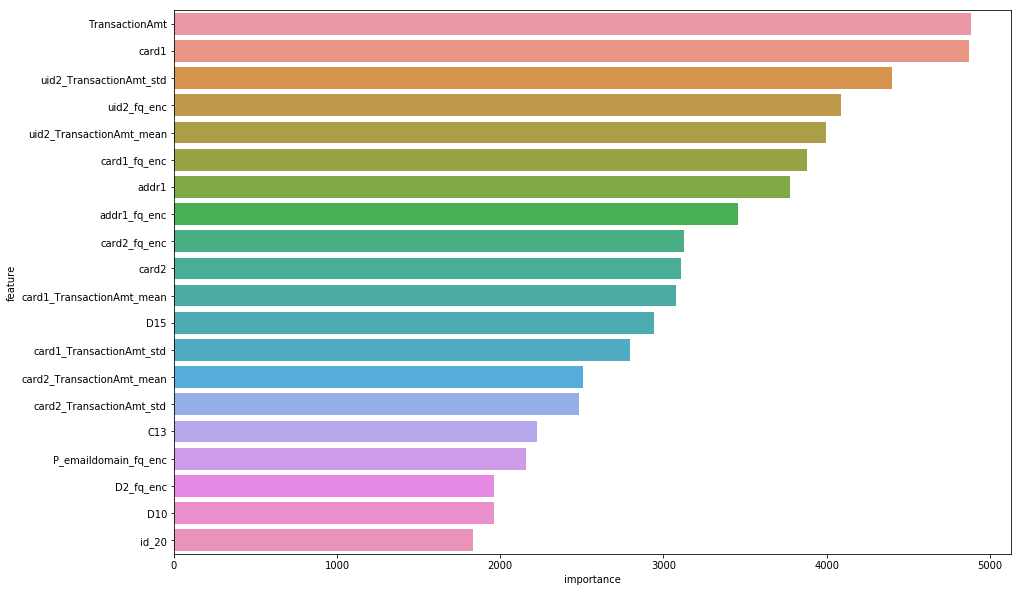

In [331]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [332]:
feature_importance_df

,feature,importance
0,TransactionAmt,4885
1,card1,4872
2,uid2_TransactionAmt_std,4398
3,uid2_fq_enc,4088
4,uid2_TransactionAmt_mean,3996
5,card1_fq_enc,3881
6,addr1,3777
7,addr1_fq_enc,3458
8,card2_fq_enc,3124
9,card2,3107


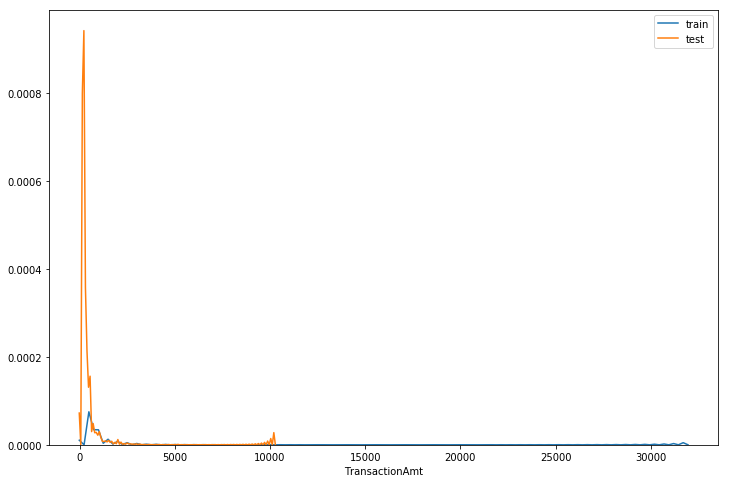

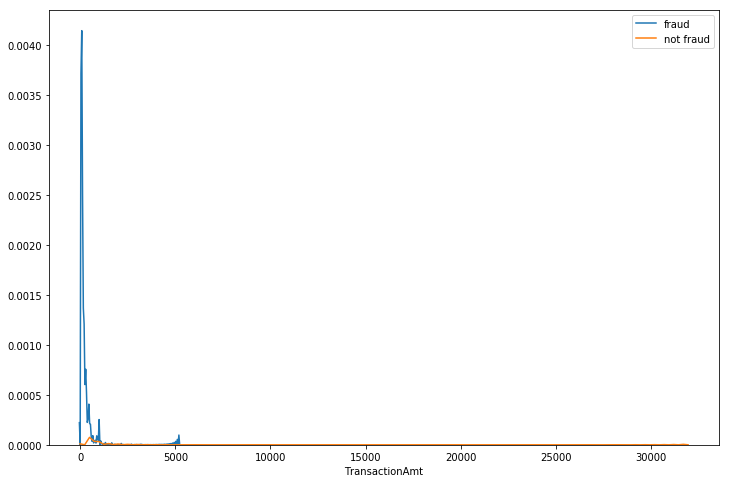

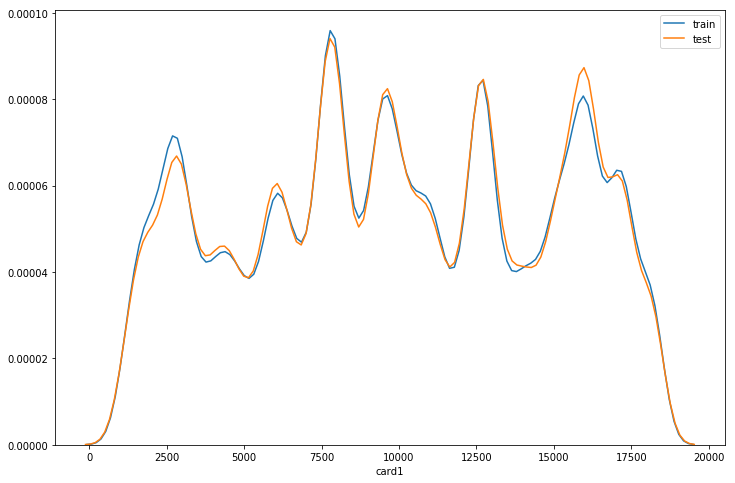

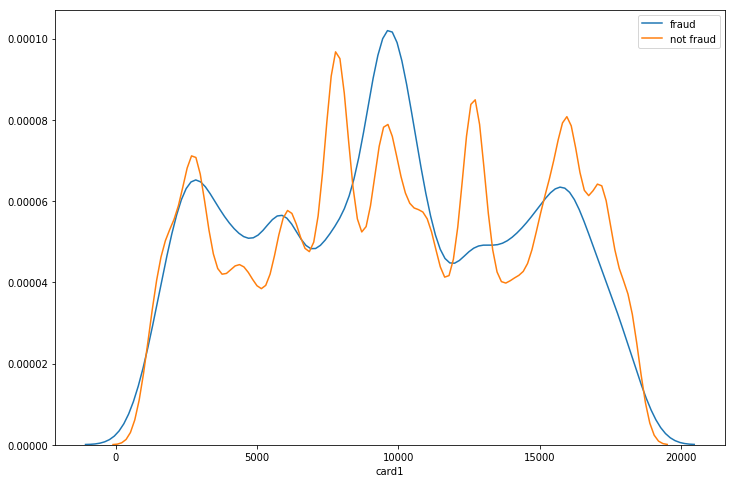

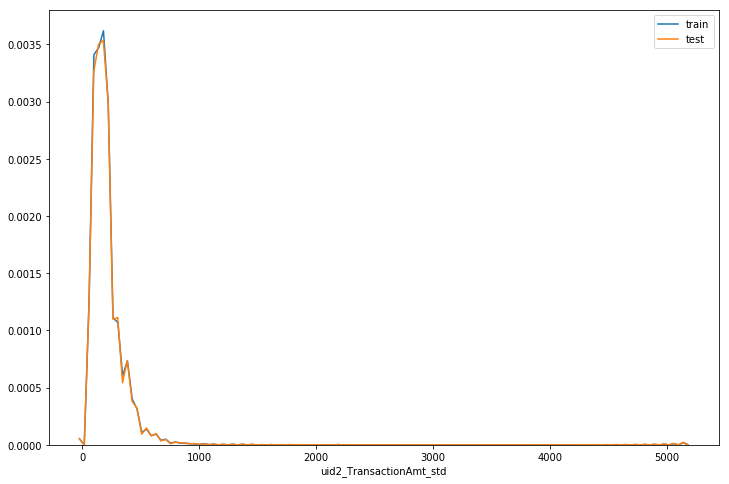

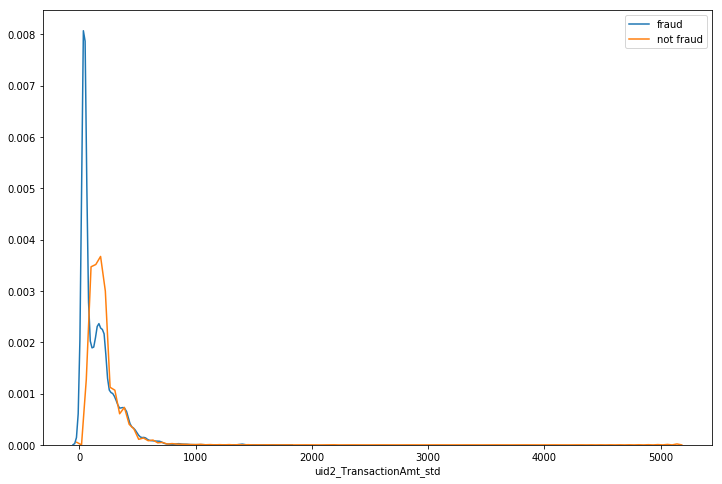

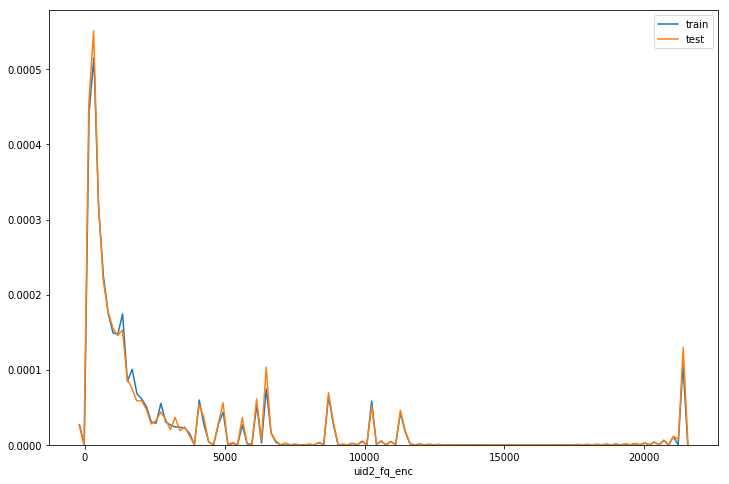

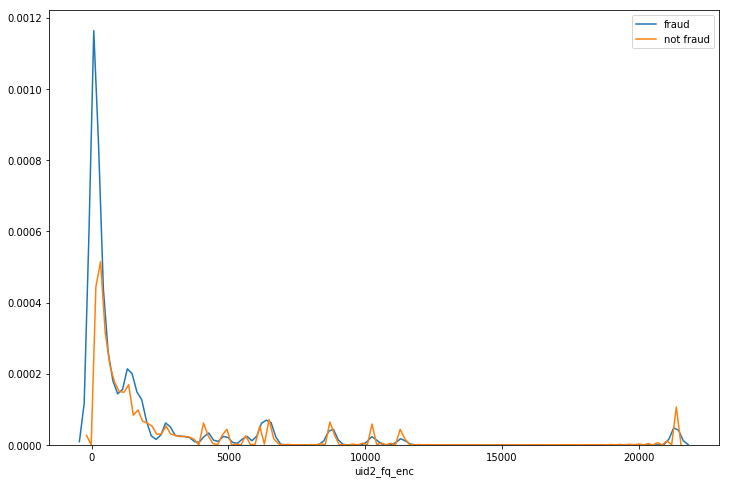

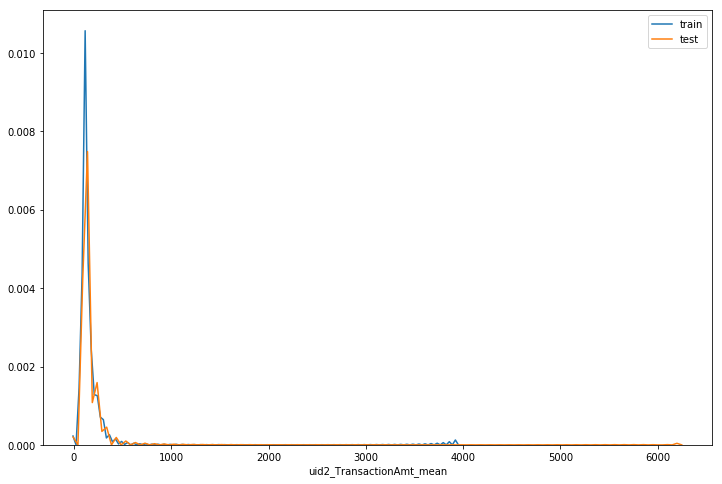

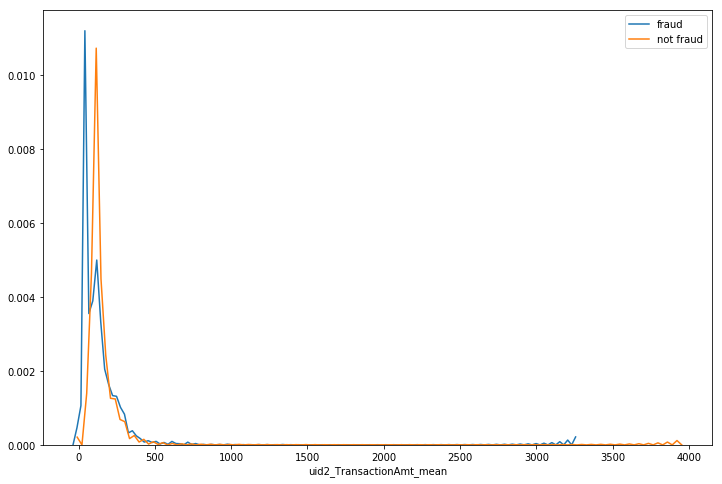

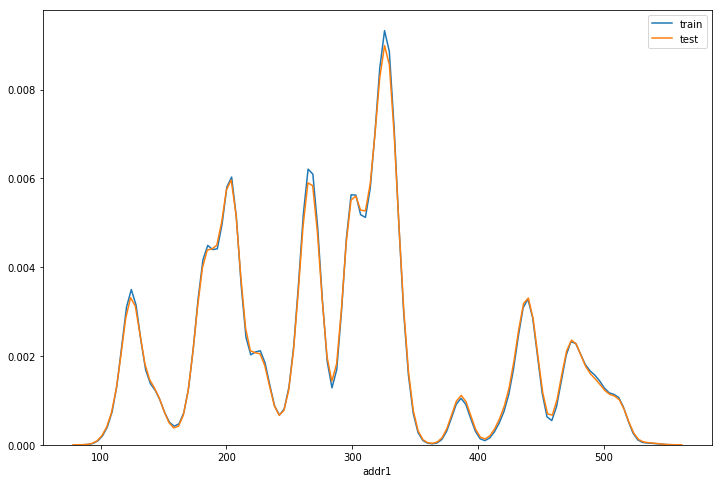

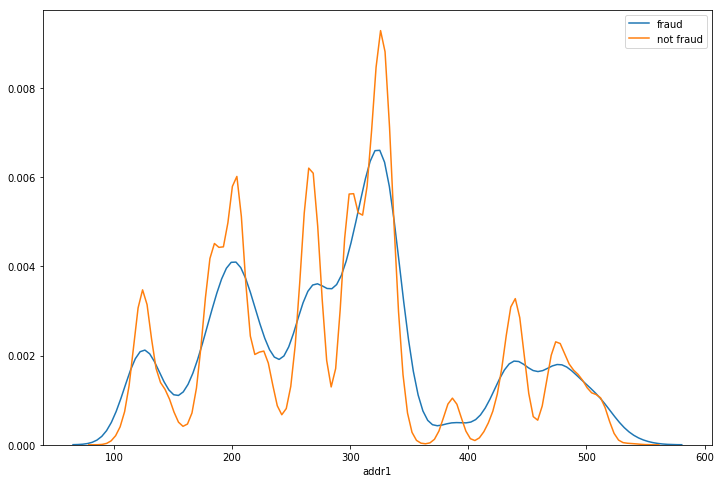

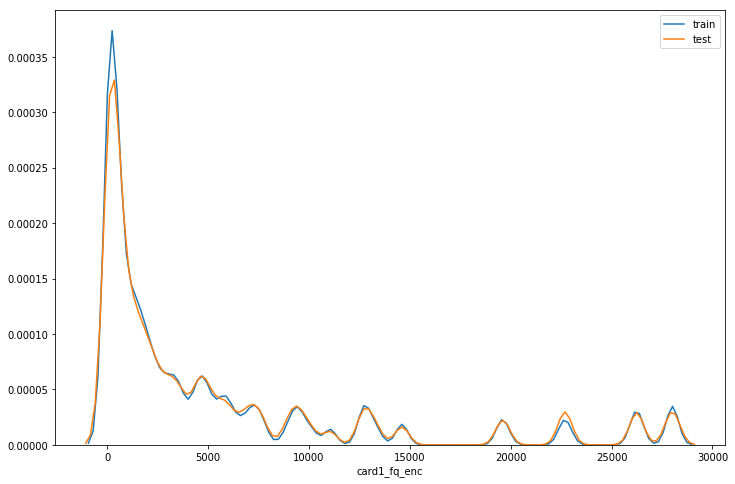

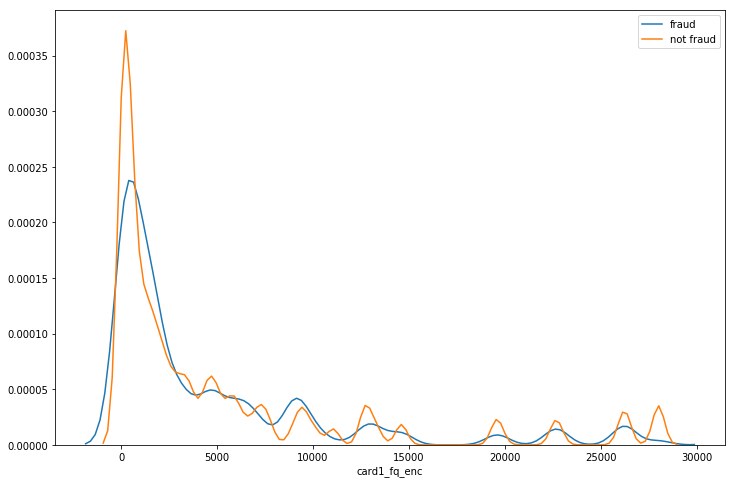

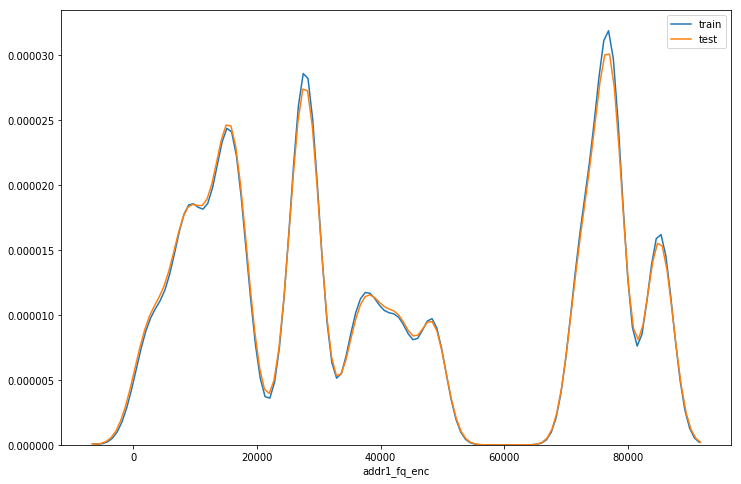

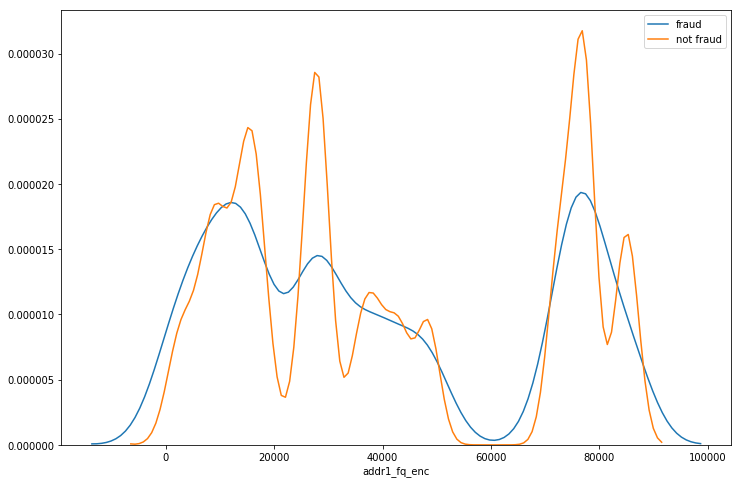

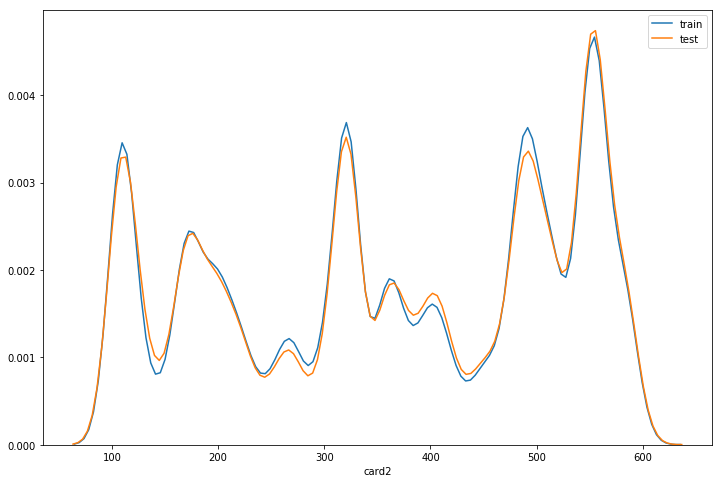

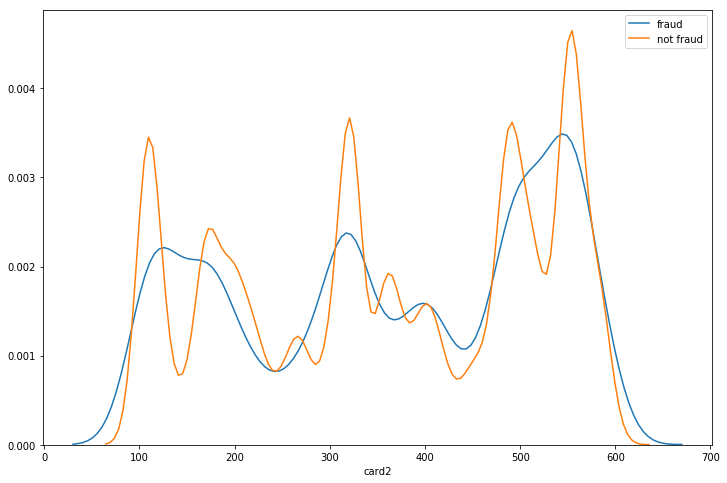

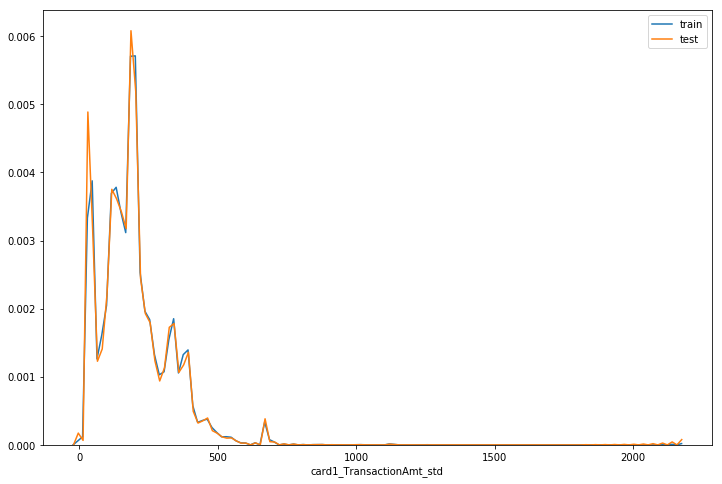

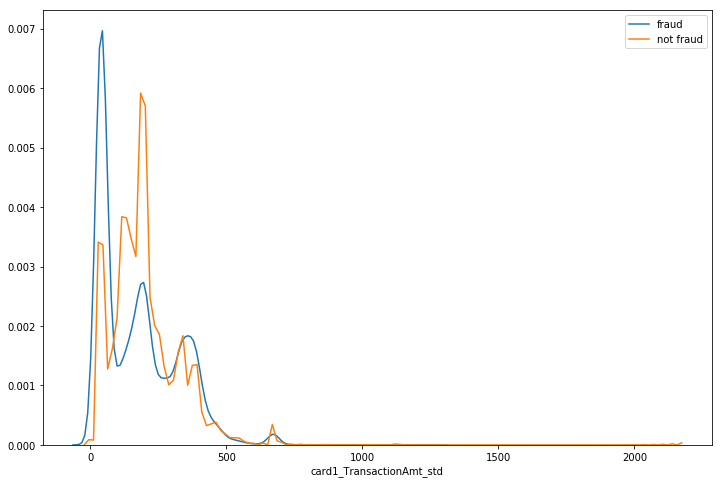

In [185]:
for feature in feature_importance_df['feature'][:10]:
    plt.figure(figsize=(12,8))
    sns.distplot(train[feature], label='train', hist=False)
    sns.distplot(test[feature], label='test', hist=False)
    plt.legend()
    plt.show()


    plt.figure(figsize=(12,8))
    sns.distplot(train[(train['isFraud'] == 1) 
                       & (train[feature].notna())][feature],
                 label='fraud', hist=False)
    sns.distplot(train[(train['isFraud'] == 0) &
                       (train[feature].notna())][feature],
                 label='not fraud', hist=False)
    plt.legend()
    plt.show()

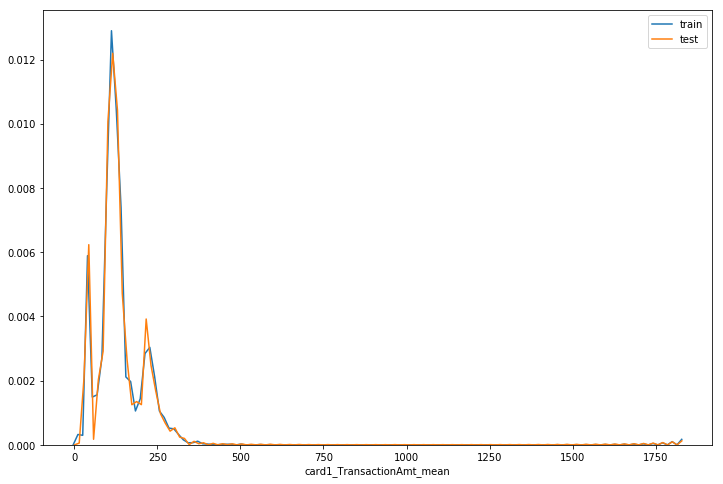

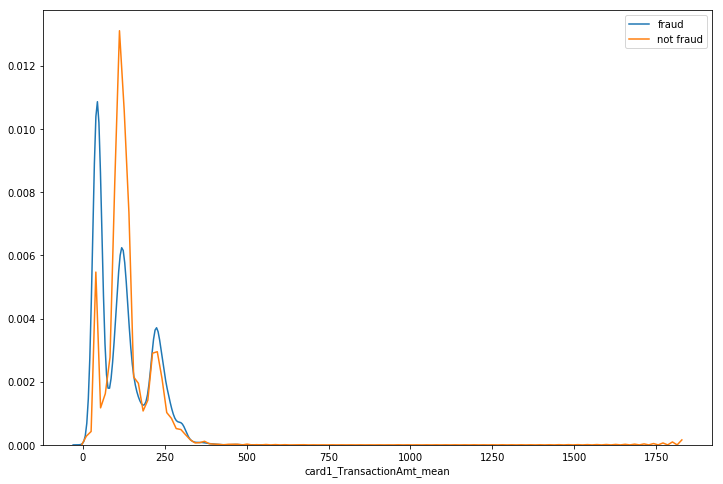

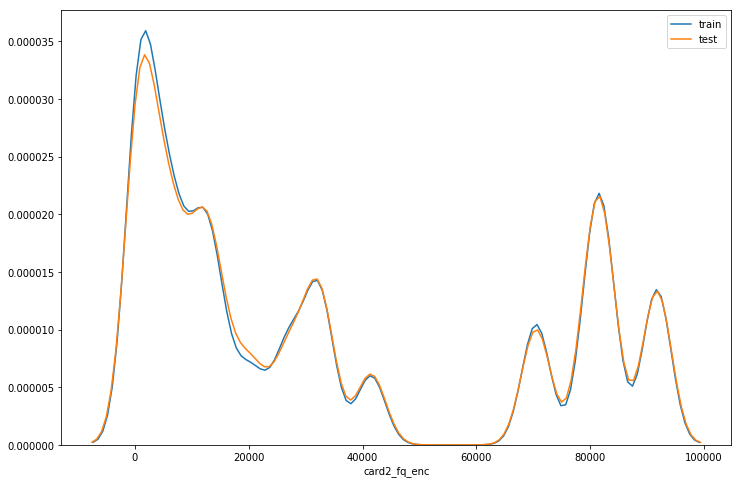

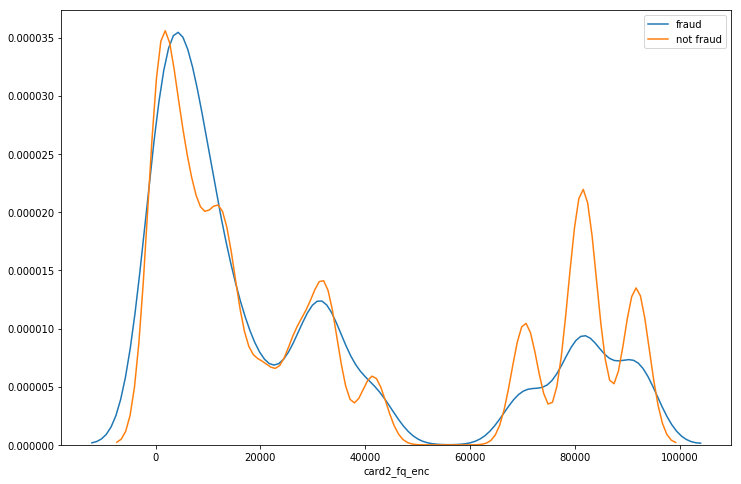

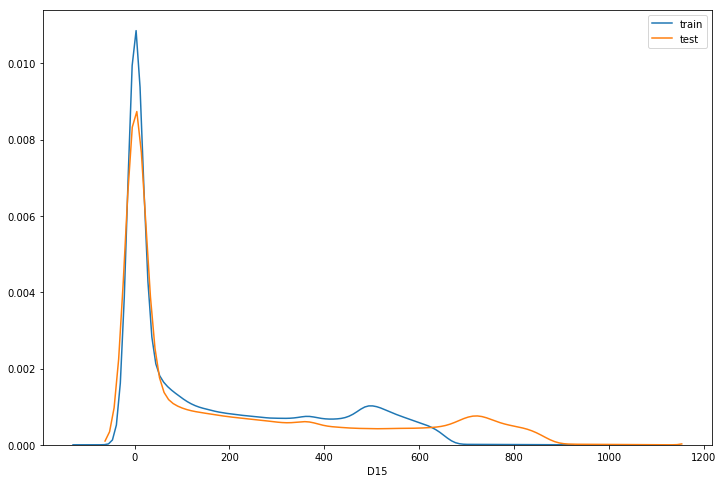

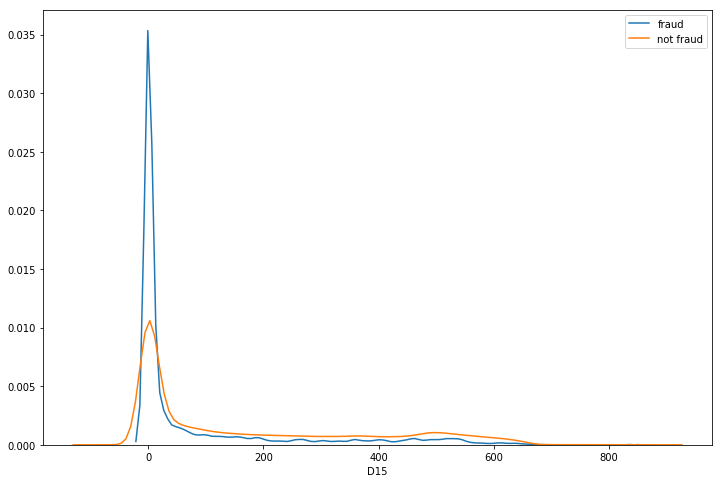

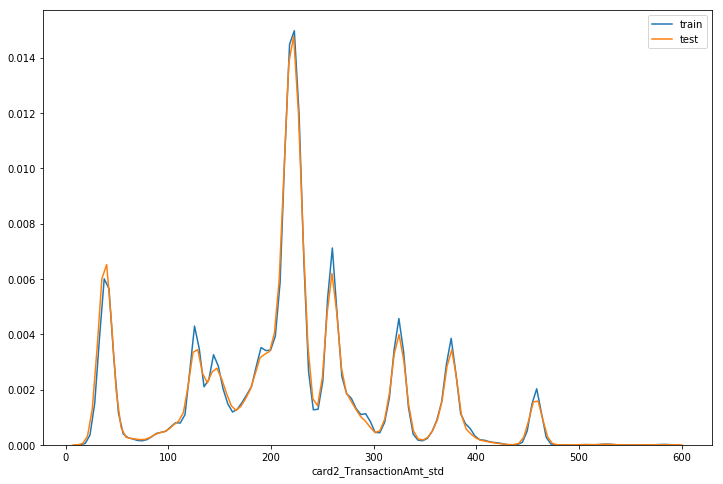

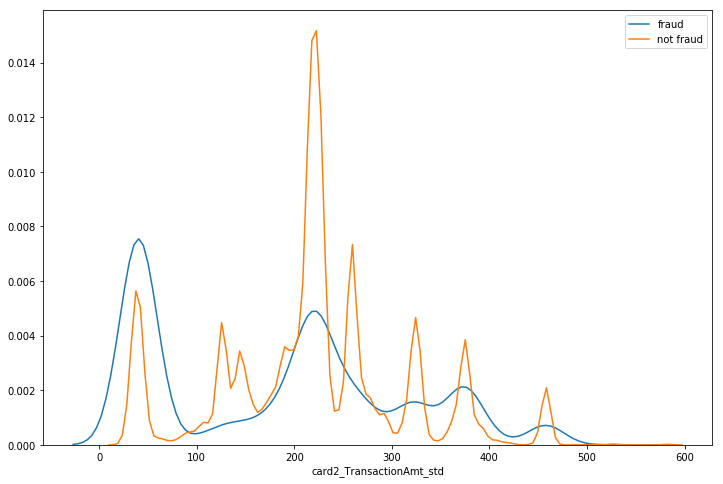

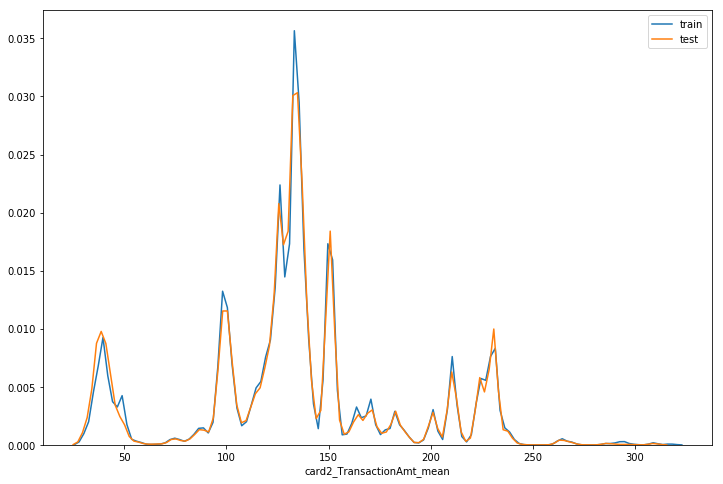

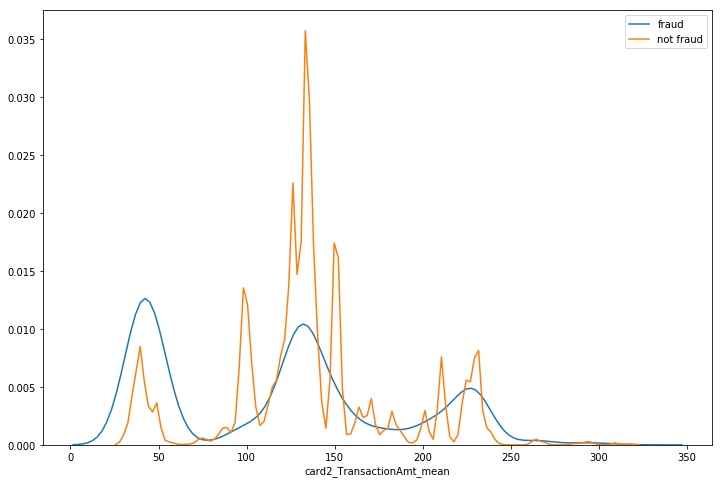

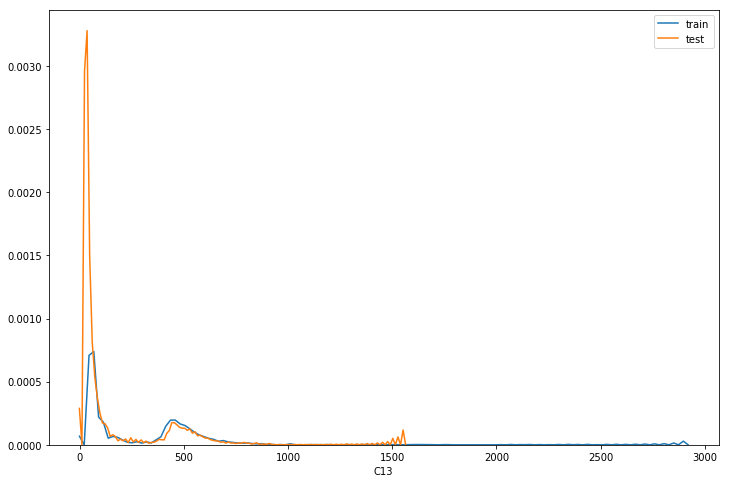

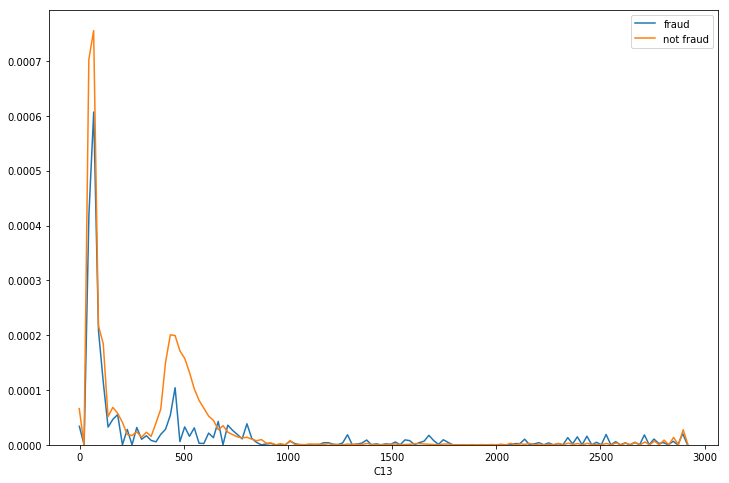

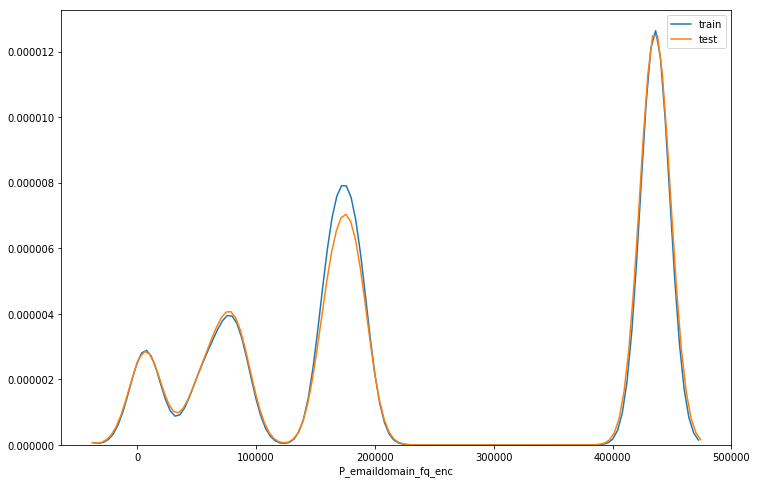

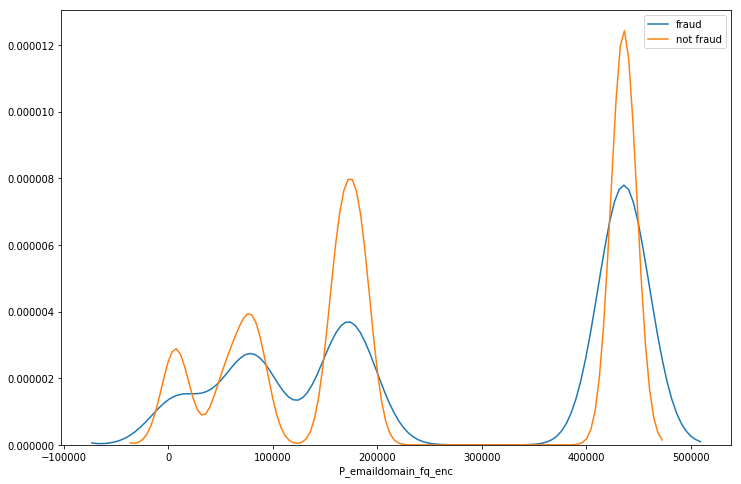

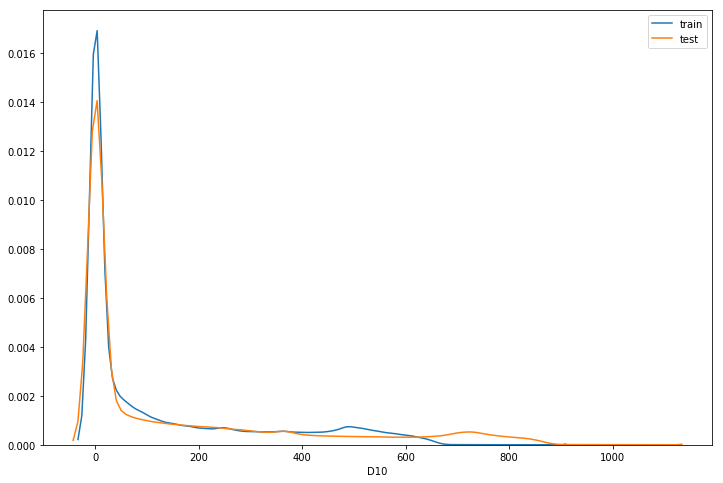

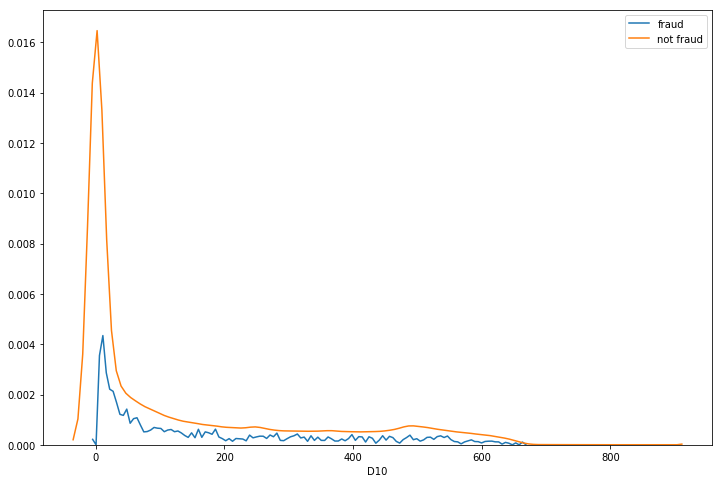

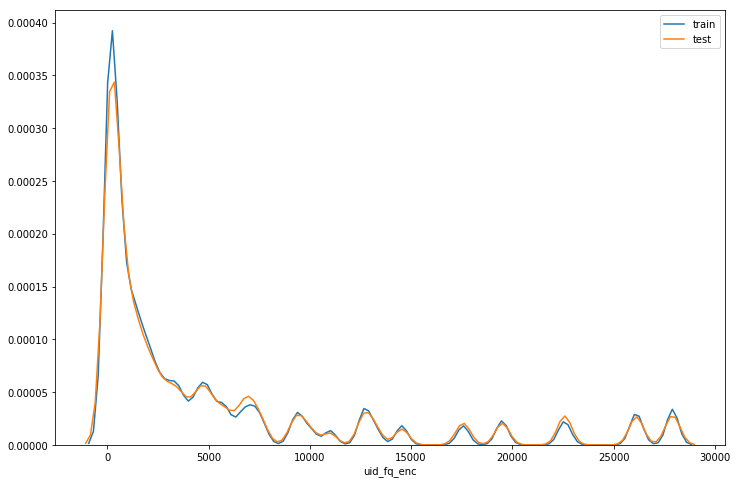

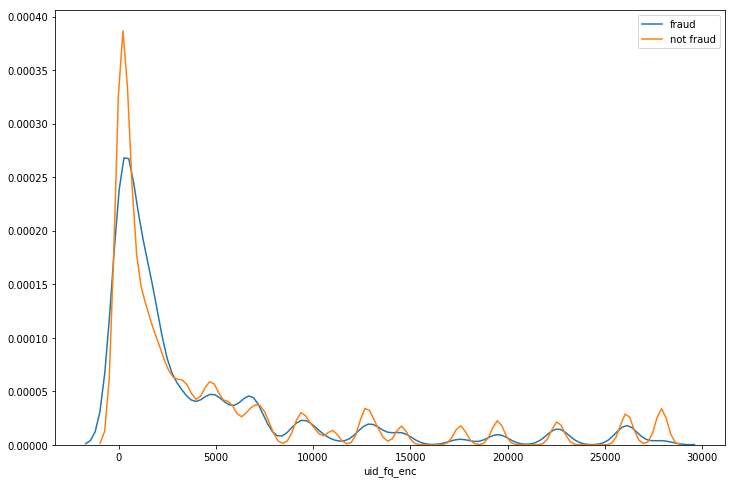

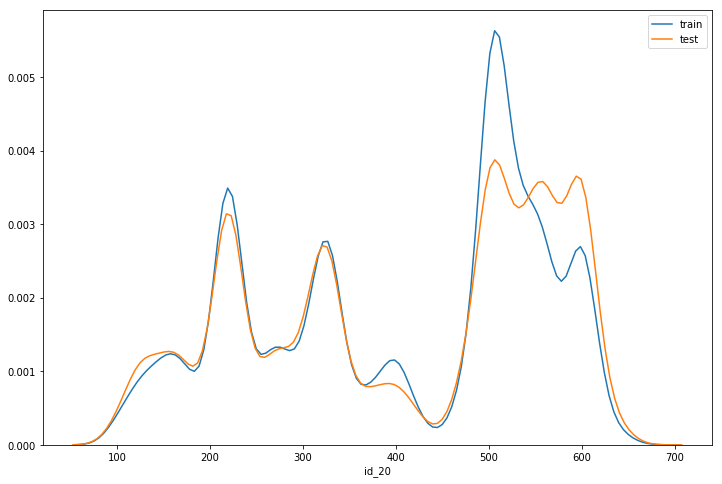

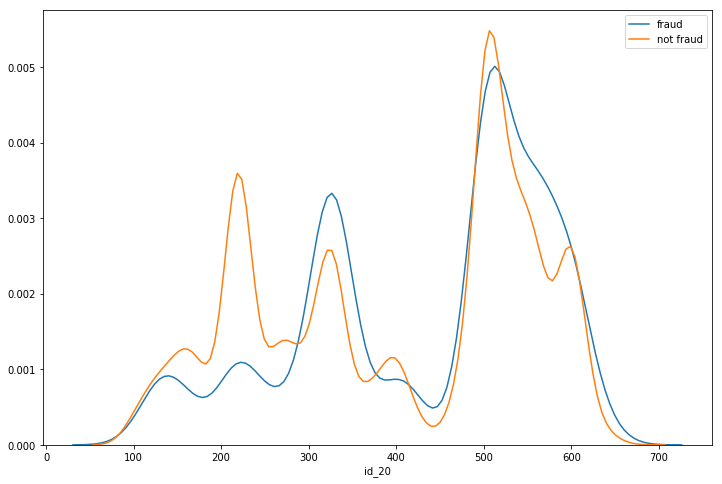

In [186]:
for feature in feature_importance_df['feature'][10:20]:
    plt.figure(figsize=(12,8))
    sns.distplot(train[feature], label='train', hist=False)
    sns.distplot(test[feature], label='test', hist=False)
    plt.legend()
    plt.show()


    plt.figure(figsize=(12,8))
    sns.distplot(train[(train['isFraud'] == 1) 
                       & (train[feature].notna())][feature],
                 label='fraud', hist=False)
    sns.distplot(train[(train['isFraud'] == 0) &
                       (train[feature].notna())][feature],
                 label='not fraud', hist=False)
    plt.legend()
    plt.show()